<a href="https://colab.research.google.com/github/Anderoids/Projects/blob/main/DepressionPredicion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
df=pd.read_csv('/content/Dataset_14-day_AA_depression_symptoms_mood_and_PHQ-9.csv',index_col = 0)

In [3]:
plt.style.use('ggplot')
np.random.seed(42)

In [4]:
df.head()

,user_id,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,...,q14,q16,q46,q47,happiness.score,time,period.name,start.time,phq.day,id
1,1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,...,0.0,NaN,NaN,NaN,2,2017-01-22 20:11:59,evening,2017-01-09 07:22:37,-0.951921,1
2,1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,...,NaN,NaN,1.0,NaN,3,2017-02-08 22:53:06,evening,2017-01-09 07:22:37,16.159965,1
3,1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,...,NaN,NaN,NaN,NaN,3,2017-02-08 08:00:46,morning,2017-01-09 07:22:37,15.540289,1
4,1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,...,NaN,1.0,NaN,NaN,2,2017-01-22 14:01:25,midday,2017-01-09 07:22:37,-1.209259,1
5,1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,...,1.0,NaN,1.0,NaN,2,2017-01-21 15:37:24,midday,2017-01-09 07:22:37,-2.142604,1


In [5]:
df.shape

(16150, 35)

In [6]:
null_counts = df.isnull().sum()

fig = go.Figure()
fig.add_trace(go.Bar(x=null_counts.index, y=null_counts.values, marker_color='teal'))

fig.update_layout(title='Number of NaN values per column', xaxis_title='Column', yaxis_title='Number of NaN values', xaxis_tickangle=-45)

fig.show()

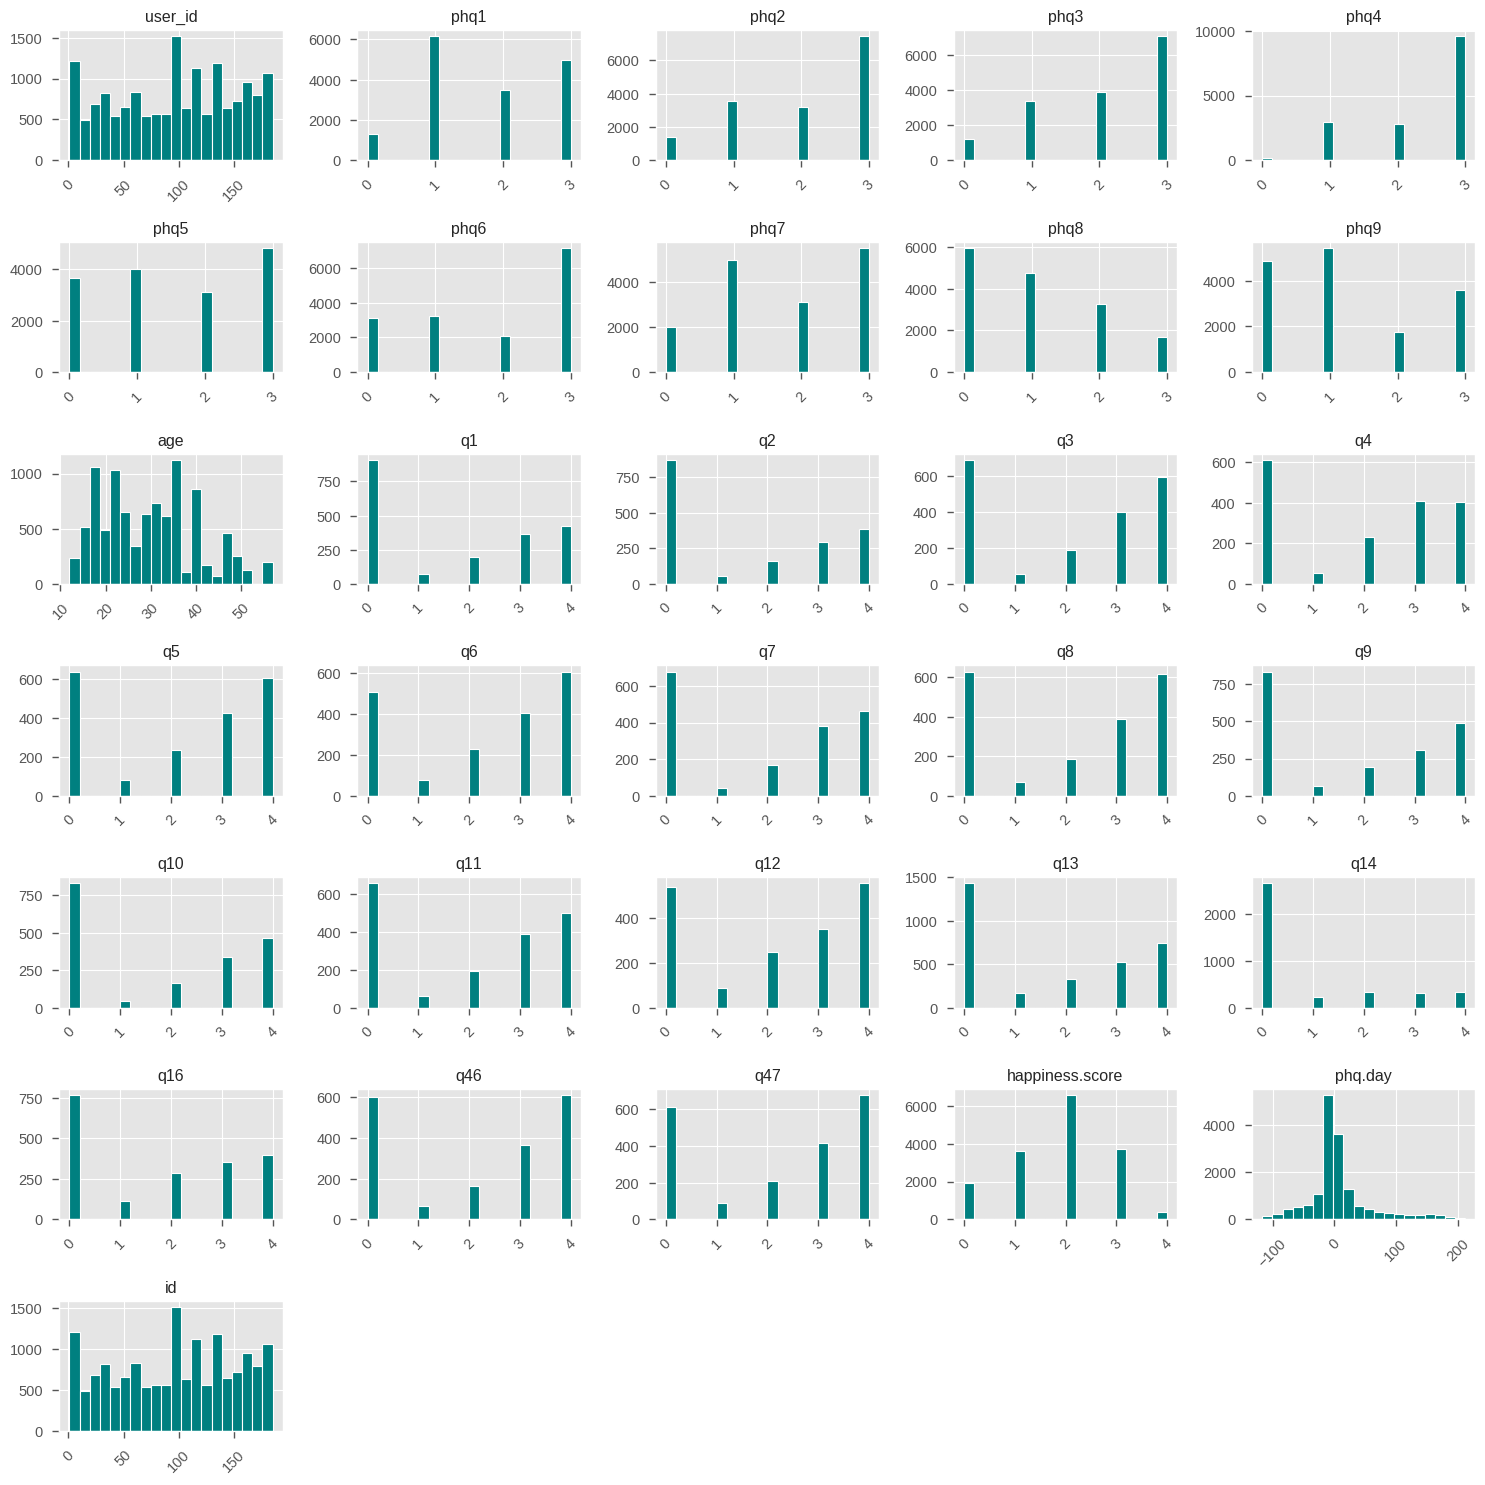

In [7]:
sns.set_context(context = 'paper', font_scale= 1.2)

axes = df.hist(bins = 20, figsize = (15,15), color = 'teal', edgecolor = 'white',
               layout=(7,5))

for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [8]:
# Converting the "time" column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Converting the "start.time" column to a datetime object
df['start.time'] = pd.to_datetime(df['start.time'])

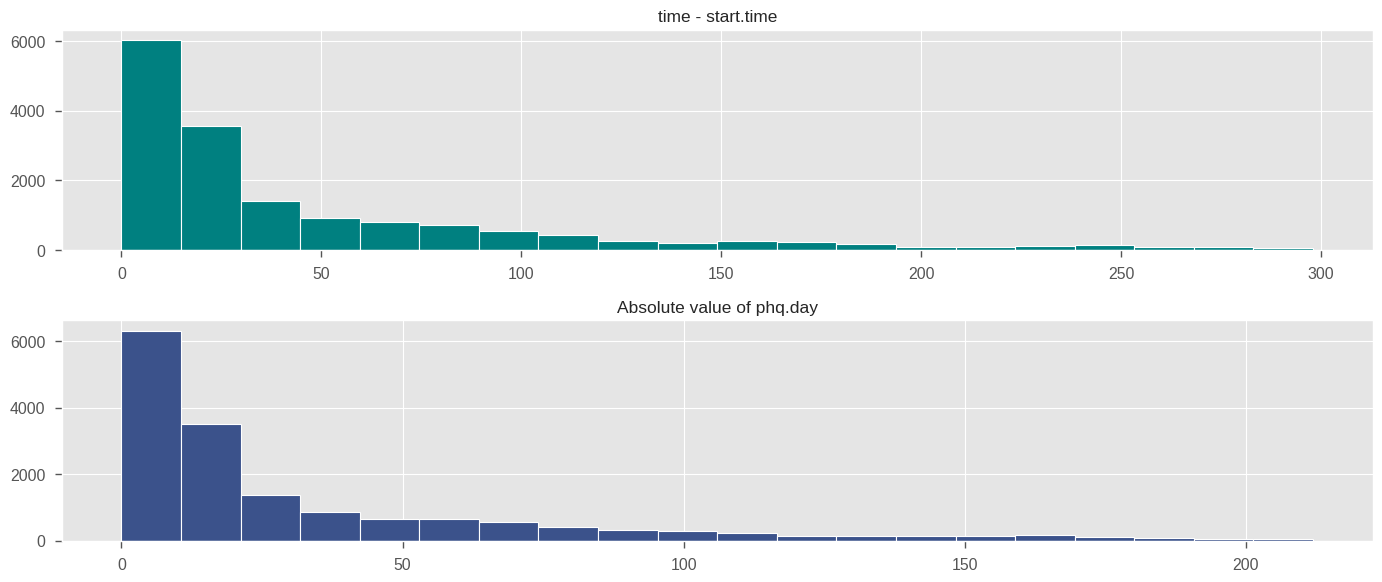

In [9]:
sns.set_context(context = 'paper', font_scale= 1.3)

plt.subplot(2,1,1)
(df['time'] - df['start.time']).dt.days.hist(bins = 20, color = 'teal',
                                             edgecolor = 'white',
                                            figsize = (14,6))
plt.title('time - start.time')

plt.subplot(2,1,2)
plt.title('Absolute value of phq.day')
df['phq.day'].abs().hist(bins = 20, color = '#3b528b', edgecolor = 'white',
                                            figsize = (14,6))

plt.tight_layout()
plt.show()


Exploratory Data Analysis



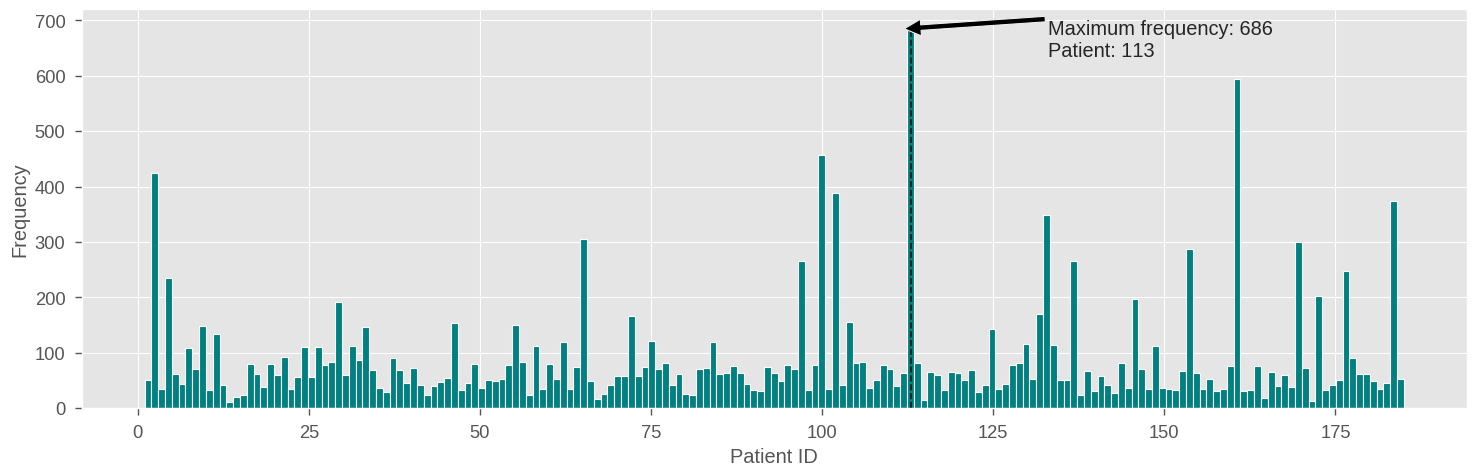

In [10]:
plt.figure(figsize = (15,5))
sns.set_context(context = 'paper', font_scale= 1.5)

plt.hist(df['id'], bins= df['id'].nunique(), color = 'teal', edgecolor = 'white')

freq_max = df['id'].value_counts().max()

bin_freq_max = df['id'].value_counts().idxmax()

plt.vlines(x=bin_freq_max, ymin=0, ymax=freq_max, color='k', linestyle='--')

plt.annotate(f'Maximum frequency: {freq_max} \nPatient: {bin_freq_max}',
             xy=(bin_freq_max - 1, freq_max - 1),
             xytext=(bin_freq_max + 20, freq_max - 50),
             arrowprops=dict(facecolor='black'))

plt.xlabel('Patient ID')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


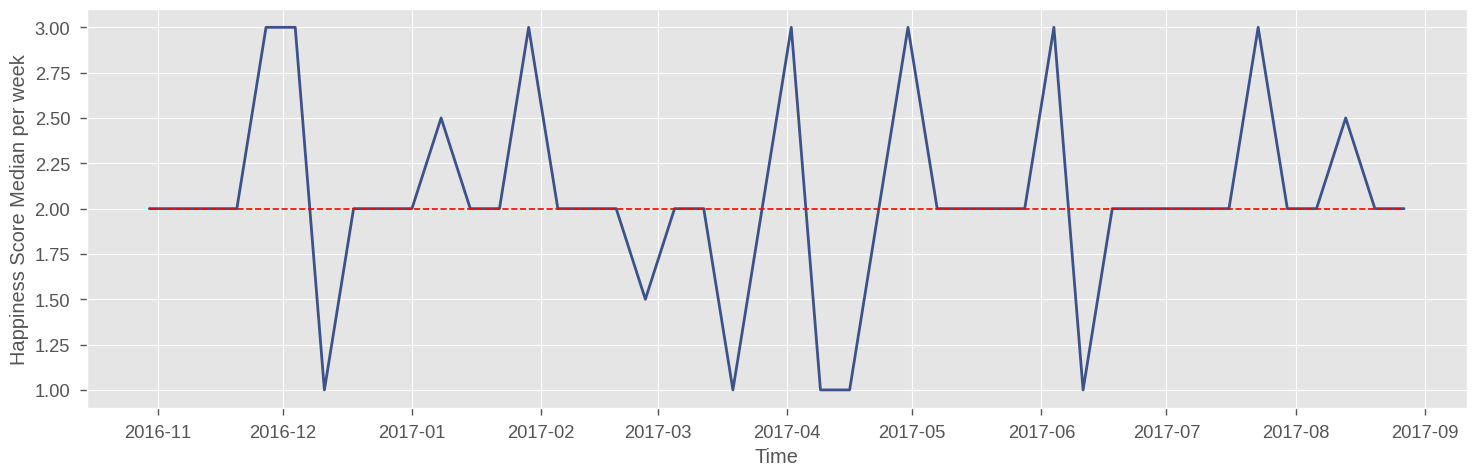

In [11]:
# Data from patient 113 grouped by week with the median of each group
patiente_113 = df[df['id'] == bin_freq_max].groupby(pd.Grouper(key='time',freq='W'))['happiness.score'].median() # Select the numeric column 'happiness.score'

plt.figure(figsize=(15, 5))
plt.plot(patiente_113.index, patiente_113.values, lw=2,  # Use .values to access the median values
         color = '#3b528b')

plt.hlines(xmin=patiente_113.index[0],
           xmax=patiente_113.index[-1],
           y=patiente_113.median(), # Calculate the median of the 'happiness.score'
           color='red',
           linestyle='--')

plt.xlabel('Time')
plt.ylabel('Happiness Score Median per week')

plt.tight_layout()
plt.show()

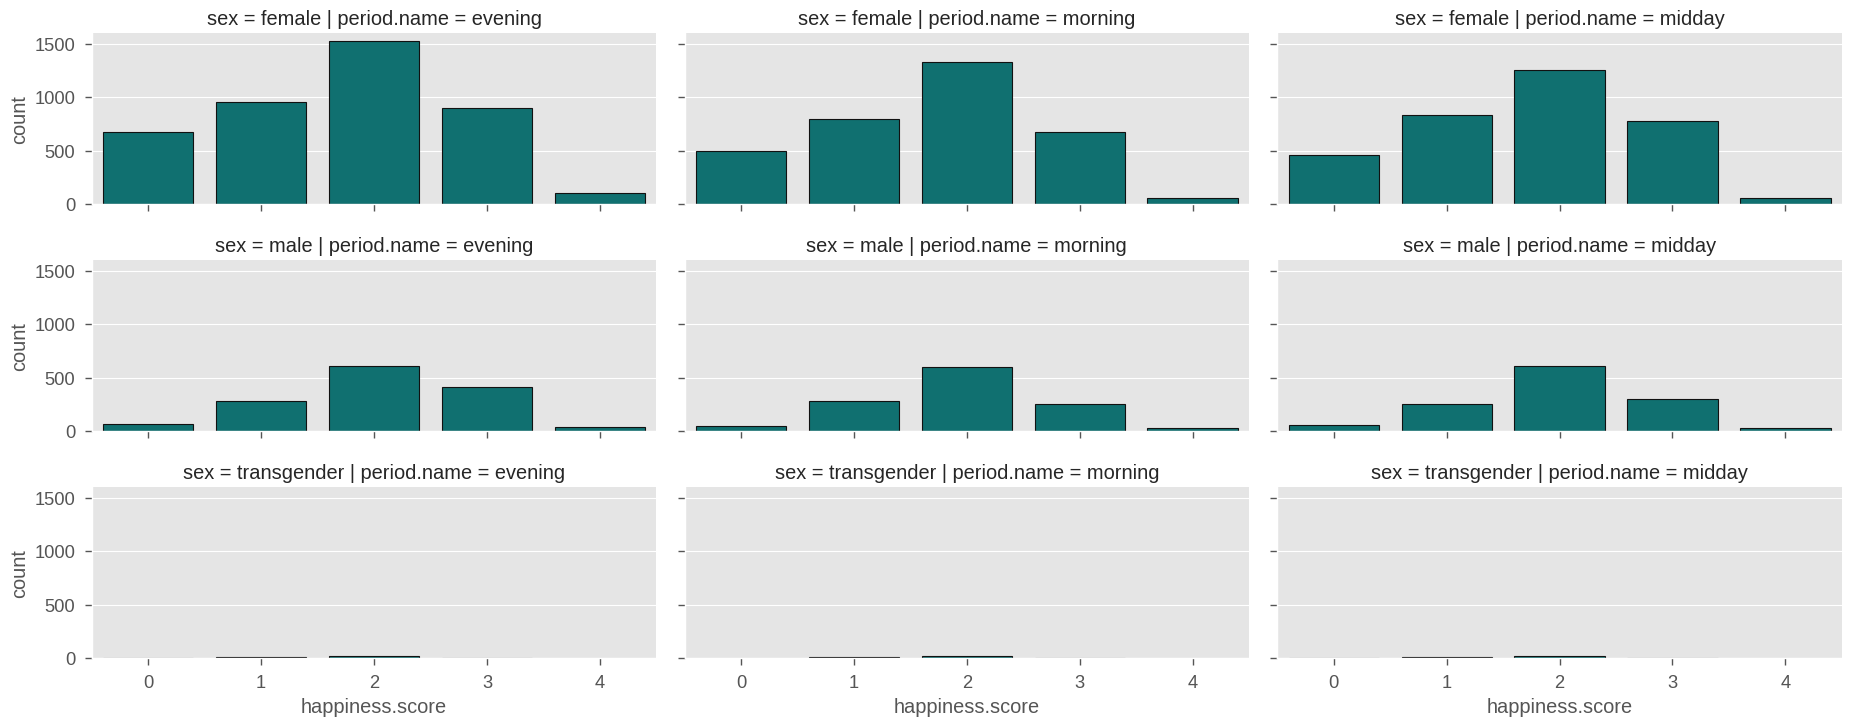

In [12]:
g = sns.FacetGrid(data = df, col= 'period.name', row = 'sex', height = 2.5,
                  aspect = 2.5)

g.map_dataframe(sns.countplot, 'happiness.score', color = 'teal',
                edgecolor = 'k')

plt.tight_layout()
plt.show()

<ipython-input-13-4ef0f44ed044>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




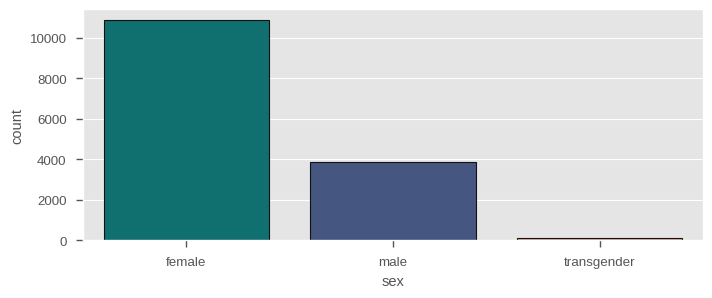

In [13]:
sns.set_context(context = 'paper', font_scale= 1.1)

plt.figure(figsize = (8,3))
sns.countplot(x = 'sex', data = df,
              palette=['teal','#3b528b', 'darksalmon'],
              edgecolor = 'k')

plt.show()

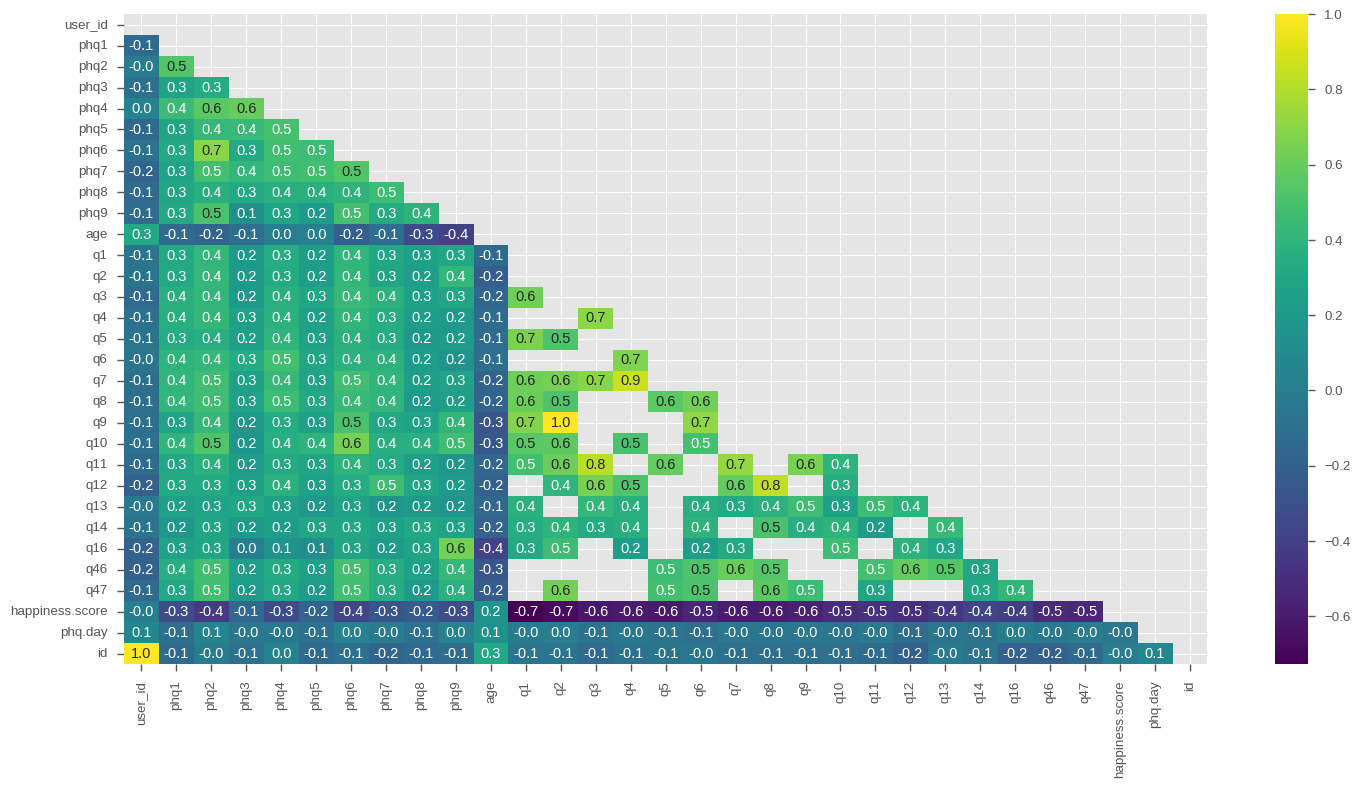

In [14]:
plt.figure(figsize=(15, 8))

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

mask = np.triu(np.ones_like(numeric_df.corr()))

sns.heatmap(numeric_df.corr(), cmap = 'viridis', mask = mask,
            annot = True, fmt='.1f')

plt.tight_layout()
plt.show()

Dealing with categorical attributes and data cleaning


In [15]:
df['total.period'] = (df['time'] - df['start.time']).dt.days

In [16]:
df = df.drop(columns = ['time', 'start.time', 'user_id', 'period.name', 'phq.day'])

In [ ]:
!pip install scikit-learn

In [17]:
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()

s = (df.dtypes == 'object')
object_cols = list(s[s].index)

for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)

In [18]:
# First let's consider that people who didn't want to identify themselves will have the 'category' unknown
df['sex'].fillna('unknown', inplace=True)

df = pd.get_dummies(df, columns=['sex'], dtype=np.int64)

In [19]:
df.head()

,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,age,...,q16,q46,q47,happiness.score,id,total.period,sex_0,sex_1,sex_2,sex_3
1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,2,1,13,0,0,0,1
2,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,3,1,30,0,0,0,1
3,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,3,1,30,0,0,0,1
4,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,1.0,NaN,NaN,2,1,13,0,0,0,1
5,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,2,1,12,0,0,0,1


In [20]:
df[df['sex_2'] == 1]['id'].unique()


array([178])

In [21]:
df[df['sex_3'] == 1]['id'].unique()

array([  1,  10,  15,  19,  20,  35,  45,  48,  56,  63,  75,  78,  80,
        98, 106, 111, 115, 118, 119, 131, 146, 150, 151, 152])

In [22]:
df.head()

,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,age,...,q16,q46,q47,happiness.score,id,total.period,sex_0,sex_1,sex_2,sex_3
1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,2,1,13,0,0,0,1
2,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,3,1,30,0,0,0,1
3,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,3,1,30,0,0,0,1
4,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,1.0,NaN,NaN,2,1,13,0,0,0,1
5,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,2,1,12,0,0,0,1


In [23]:
df = df[df['sex_2'] == 0]
df = df.drop('sex_2', axis=1)

In [24]:
df['depression_severity'] = df[['phq1', 'phq2', 'phq3','phq4', 'phq5', 'phq6','phq7', 'phq8', 'phq9']].sum(axis=1)

In [25]:
df = df.drop(columns = ['phq1', 'phq2', 'phq3','phq4', 'phq5', 'phq6','phq7', 'phq8', 'phq9'])

In [26]:
df = df.drop(columns = ['q1', 'q2', 'q3','q4', 'q5', 'q6','q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q16', 'q46', 'q47'])

In [27]:
df.isnull().sum()

,0
age,6456
happiness.score,0
id,0
total.period,0
sex_0,0
sex_1,0
sex_3,0
depression_severity,0


In [28]:
df = df[~df['age'].isnull()]

In [29]:
df[df['sex_3'] == 1]['id'].unique()

array([131])

In [30]:
df = df[df['sex_3'] == 0]
df = df.drop('sex_3', axis=1)

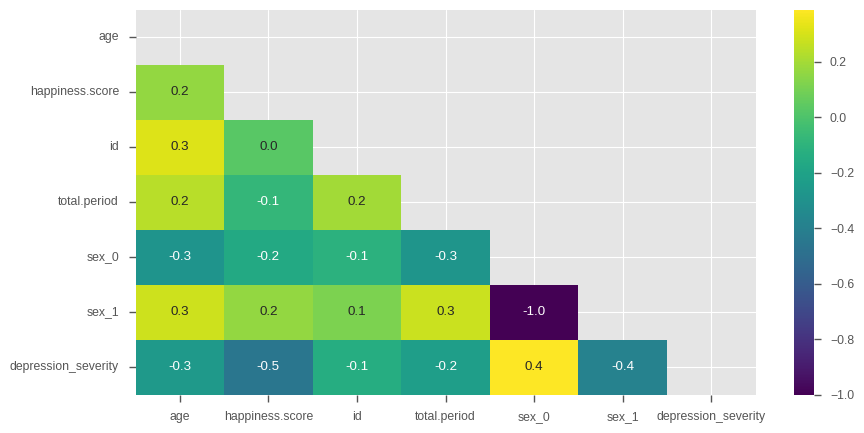

In [31]:
sns.set_context(context = 'paper', font_scale= 1)

plt.figure(figsize=(10, 5))

mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(df.corr(), cmap = 'viridis', mask = mask,
            annot = True, fmt='.1f')

plt.show()

In [32]:
df_id = df.groupby('id').median()
df_id.head()

,age,happiness.score,total.period,sex_0,sex_1,depression_severity
id,,,,,,
3,22.0,2.0,6.5,1.0,0.0,8.0
4,17.0,2.0,56.5,1.0,0.0,17.0
6,24.0,2.0,68.5,1.0,0.0,18.0
7,16.0,0.0,23.0,1.0,0.0,23.0
8,26.0,2.0,12.0,1.0,0.0,10.0


In [33]:
df = df.drop('id', axis = 1)
df.head()

,age,happiness.score,total.period,sex_0,sex_1,depression_severity
477,22.0,2,9,1,0,8.0
478,22.0,2,0,1,0,8.0
479,22.0,2,12,1,0,8.0
480,22.0,2,10,1,0,8.0
481,22.0,2,9,1,0,8.0


In [35]:
print('Shape df by id:', df_id.shape)
print('Shape df without id:', df.shape)

Shape df by id: (109, 6)
Shape df without id: (9552, 6)


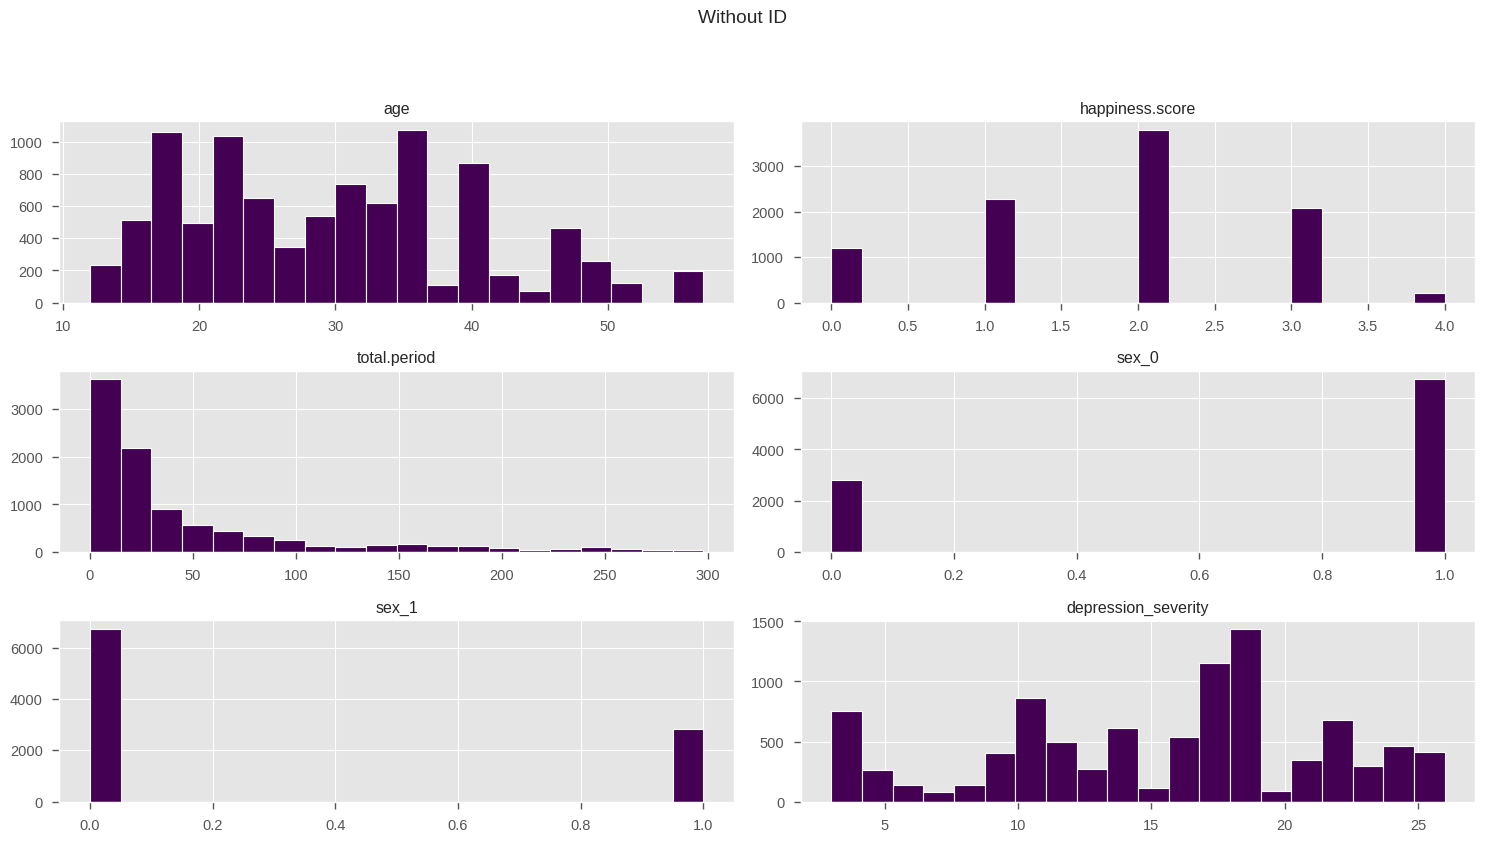

In [34]:
sns.set_context(context = 'paper', font_scale= 1.2)

df.hist(figsize = (15,8), color = '#440154', edgecolor = 'white', bins = 20)

plt.suptitle('Without ID', y = 1.05)

plt.tight_layout()
plt.show()

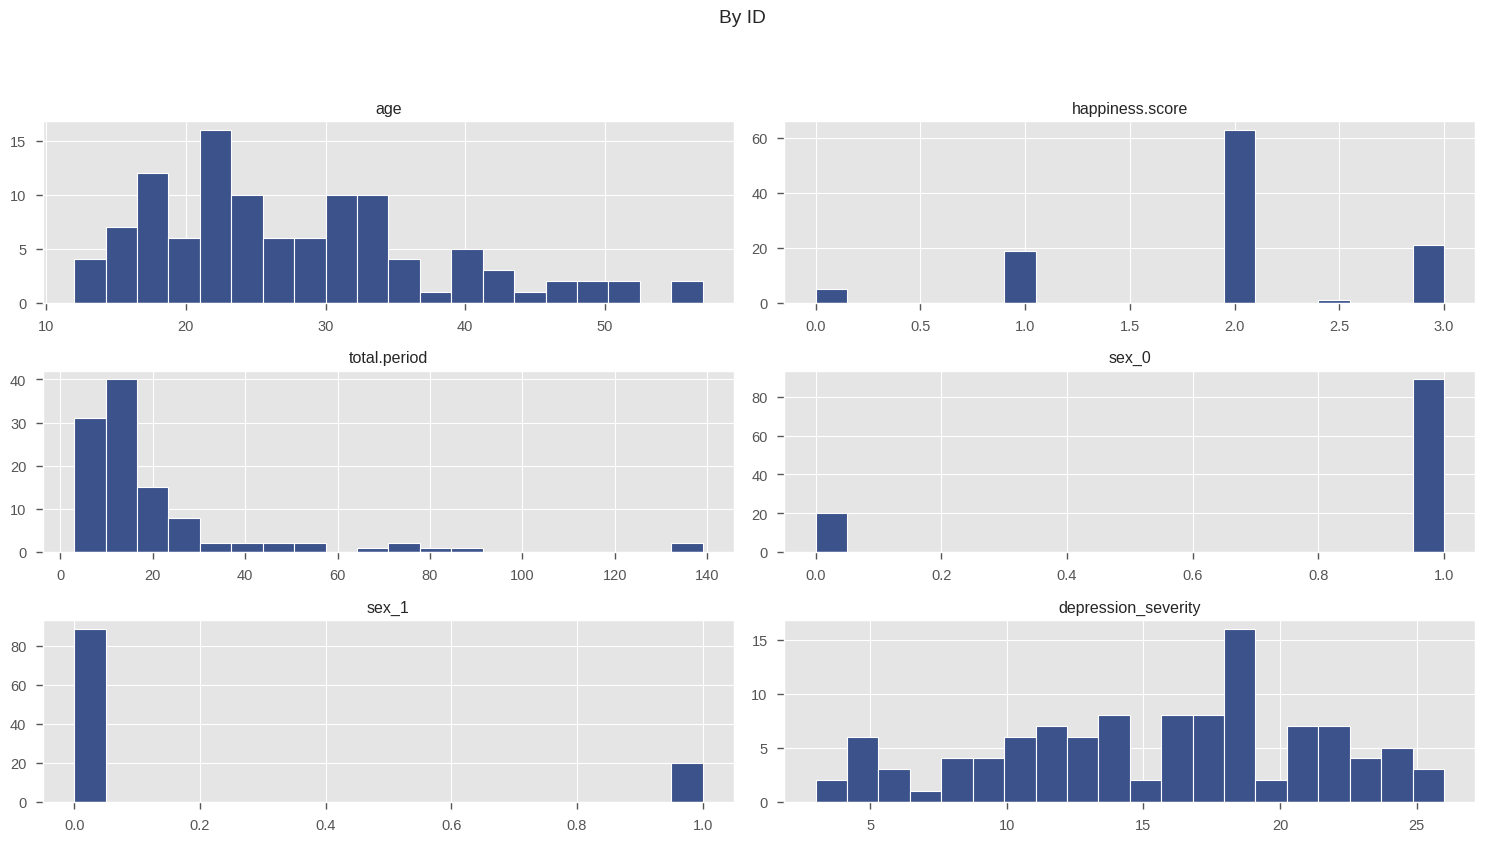

In [36]:
df_id.hist(figsize = (15,8), color = '#3b528b', edgecolor = 'white', bins = 20)

plt.suptitle('By ID', y = 1.05)

plt.tight_layout()
plt.show()

Data Pre-processing

In [37]:
df.describe()

,age,happiness.score,total.period,sex_0,sex_1,depression_severity
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,29.766122,1.770519,46.278685,0.704774,0.295226,15.360134
std,10.592496,0.996958,60.340815,0.456168,0.456168,6.042421
min,12.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,21.000000,1.000000,9.000000,0.000000,0.000000,11.000000
50%,29.000000,2.000000,21.000000,1.000000,0.000000,17.000000
75%,36.000000,2.000000,56.000000,1.000000,1.000000,19.000000
max,57.000000,4.000000,298.000000,1.000000,1.000000,26.000000


In [38]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)

In [39]:
scaled_df.head()

,age,happiness.score,total.period,sex_0,sex_1,depression_severity
0,-0.73321,0.230193,-0.617834,0.647221,-0.647221,-1.218141
1,-0.73321,0.230193,-0.766995,0.647221,-0.647221,-1.218141
2,-0.73321,0.230193,-0.568114,0.647221,-0.647221,-1.218141
3,-0.73321,0.230193,-0.601261,0.647221,-0.647221,-1.218141
4,-0.73321,0.230193,-0.617834,0.647221,-0.647221,-1.218141


Optimal Cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

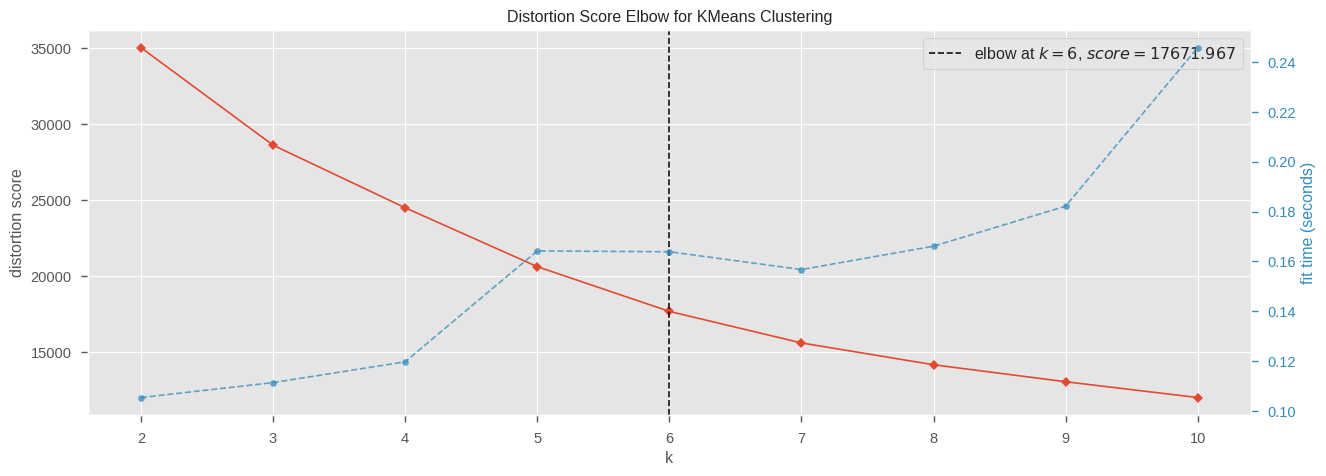

<Figure size 800x550 with 0 Axes>

In [40]:
plt.figure(figsize=(15, 5))

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled_df)
Elbow_M.show()

plt.tight_layout()
plt.show()

In [41]:
kmeans = KMeans(n_clusters = 5)

kmeans.fit_predict(scaled_df)

score = silhouette_score(scaled_df, kmeans.labels_, metric='euclidean')
print('Silhouetter Average Score: %.3f' % score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouetter Average Score: 0.304


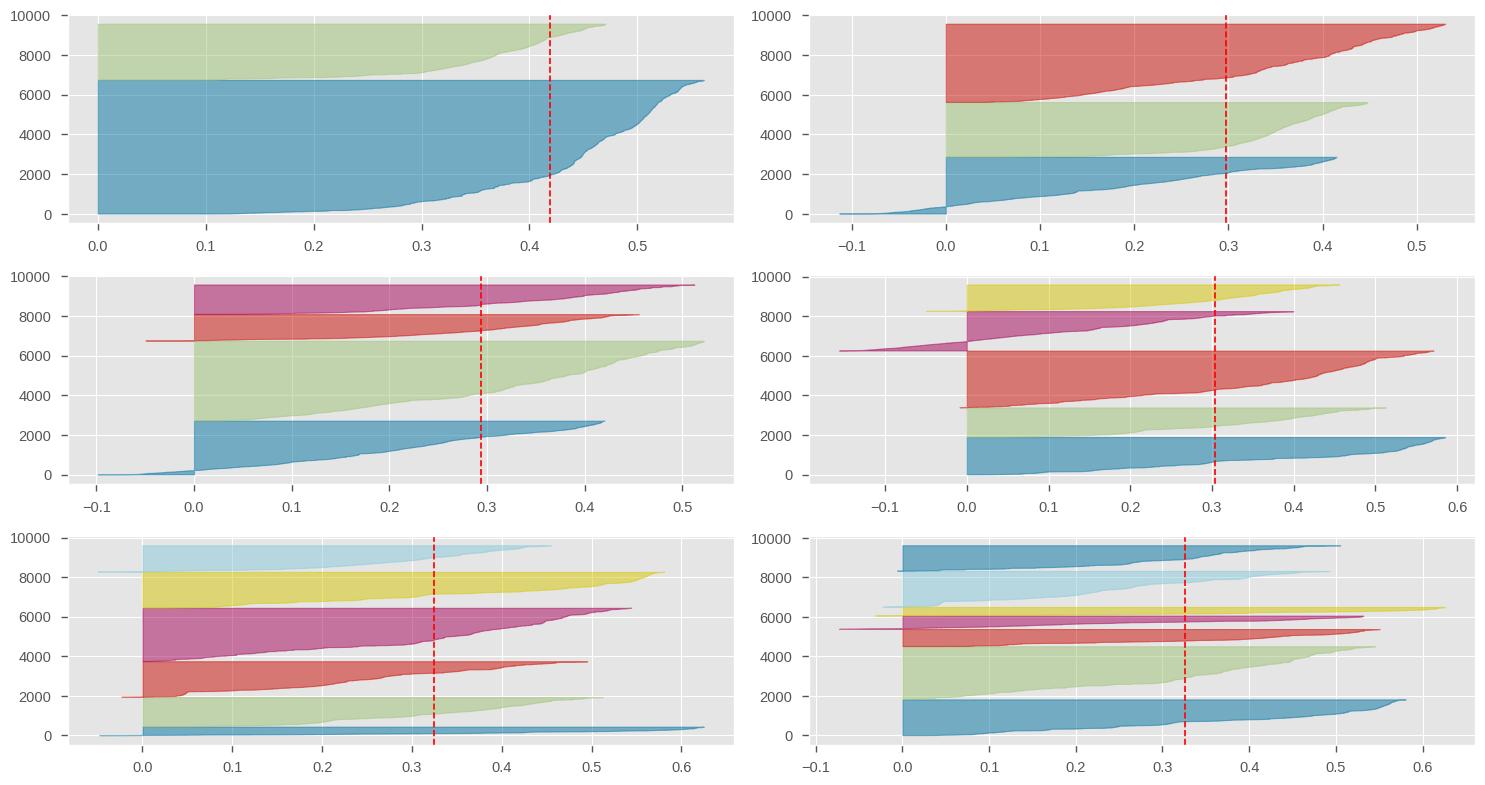

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))

for i in range(2,8):
    kmeans = KMeans(n_clusters = i,
                    init='k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(kmeans,
                                      colors='yellowbrick',
                                      ax=ax[q-1][mod])
    visualizer.fit(scaled_df)

plt.tight_layout()
plt.show()

In [43]:
kmeans = KMeans(n_clusters = 5)

yhat = kmeans.fit_predict(scaled_df)

# Adding the Clusters to the original dataframe
df["Clusters"] = yhat

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [44]:
df.head()

,age,happiness.score,total.period,sex_0,sex_1,depression_severity,Clusters
477,22.0,2,9,1,0,8.0,0
478,22.0,2,0,1,0,8.0,0
479,22.0,2,12,1,0,8.0,0
480,22.0,2,10,1,0,8.0,0
481,22.0,2,9,1,0,8.0,0


Cluster Analysis

In [45]:
palette = {'color': ['#440154', '#bc3754', '#21918c', '#a0da39', '#fde725'],
           'Clusters': [0, 1, 2, 3, 4]}

palette['color']

['#440154', '#bc3754', '#21918c', '#a0da39', '#fde725']

<ipython-input-46-1e5100a0c31e>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




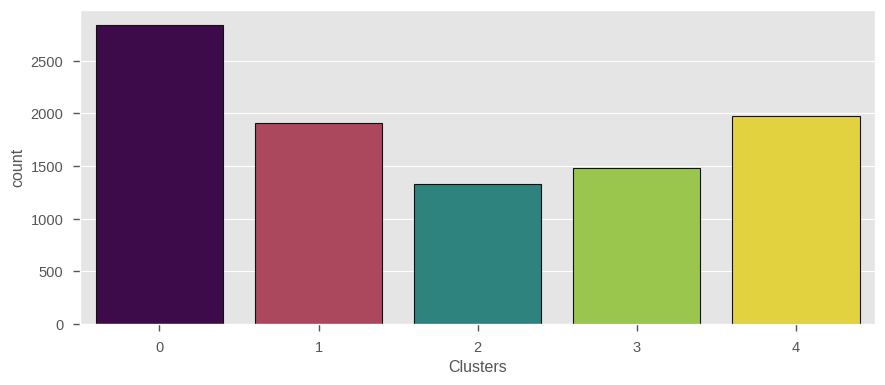

In [46]:
plt.figure(figsize = (9,4))

sns.countplot(x=df['Clusters'], edgecolor = 'k', palette = palette['color'])

plt.tight_layout()
plt.show()

In [47]:
df_fem = df[df['sex_0'] == 1]
df_mal = df[df['sex_1'] == 1]

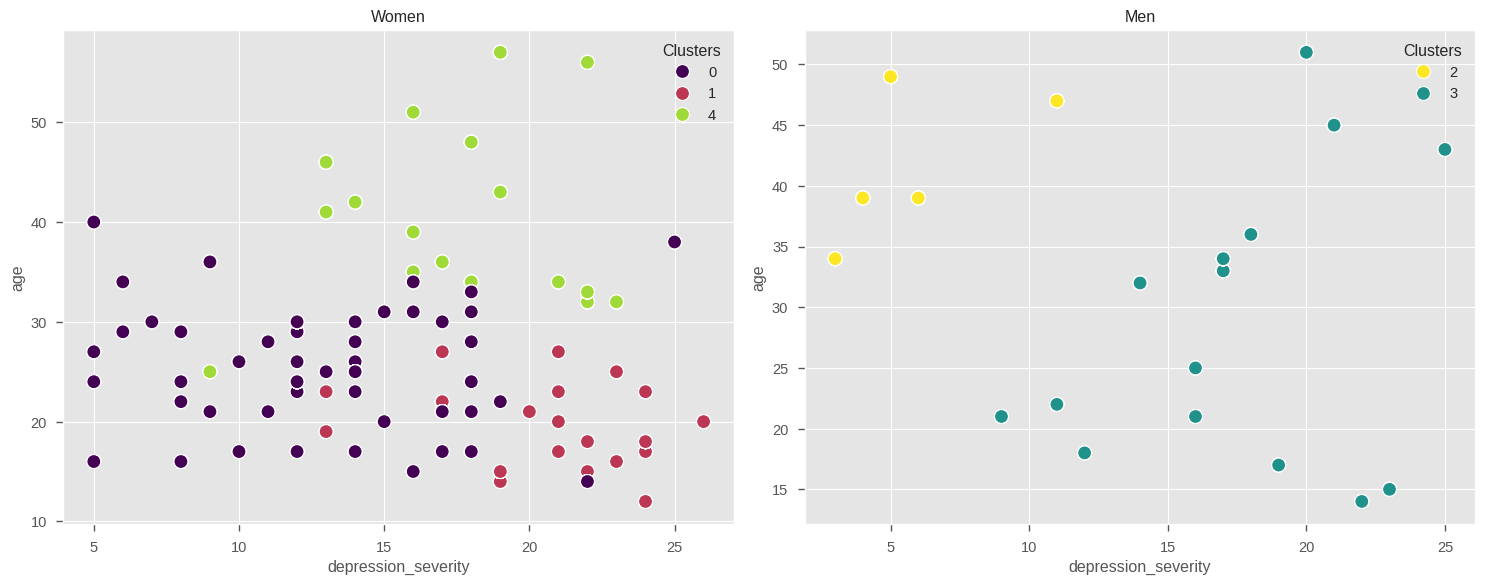

In [48]:
plt.figure(figsize = (15,6))

ax = plt.subplot(1,2,1)
sns.scatterplot(data = df_fem, x = 'depression_severity', y = 'age', hue = 'Clusters',
                palette = ['#440154', '#bc3754', '#a0da39'],
                ax = ax, s = 100)
plt.title('Women')

ax = plt.subplot(1,2,2)
sns.scatterplot(data = df_mal, x = 'depression_severity', y = 'age', hue = 'Clusters',
                palette = ['#fde725', '#21918c'],
                ax = ax, s = 100)
plt.title('Men')

plt.tight_layout()
plt.show()

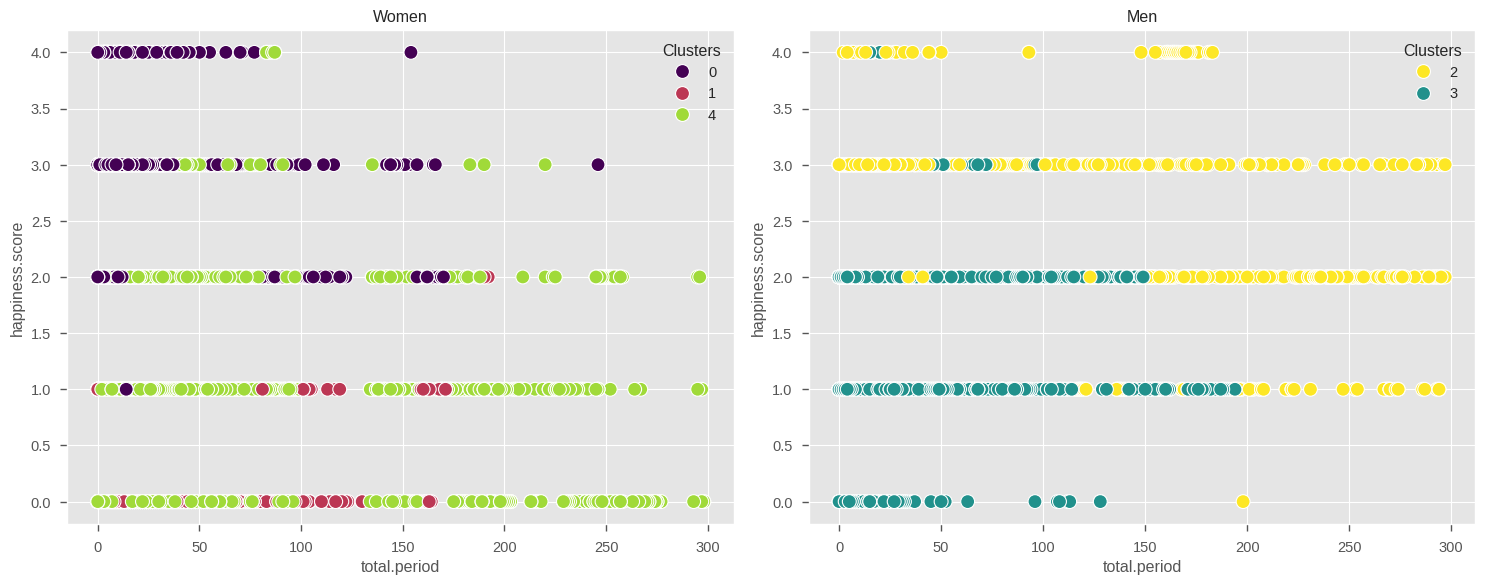

In [49]:
plt.figure(figsize = (15,6))

ax = plt.subplot(1,2,1)
sns.scatterplot(data = df_fem, x = 'total.period', y = 'happiness.score', hue = 'Clusters',
                palette = ['#440154', '#bc3754', '#a0da39'],
                ax = ax, s = 100)
plt.title('Women')

ax = plt.subplot(1,2,2)
sns.scatterplot(data = df_mal, x = 'total.period', y = 'happiness.score', hue = 'Clusters',
                palette = ['#fde725', '#21918c'],
                ax = ax, s = 100)
plt.title('Men')

plt.tight_layout()
plt.show()

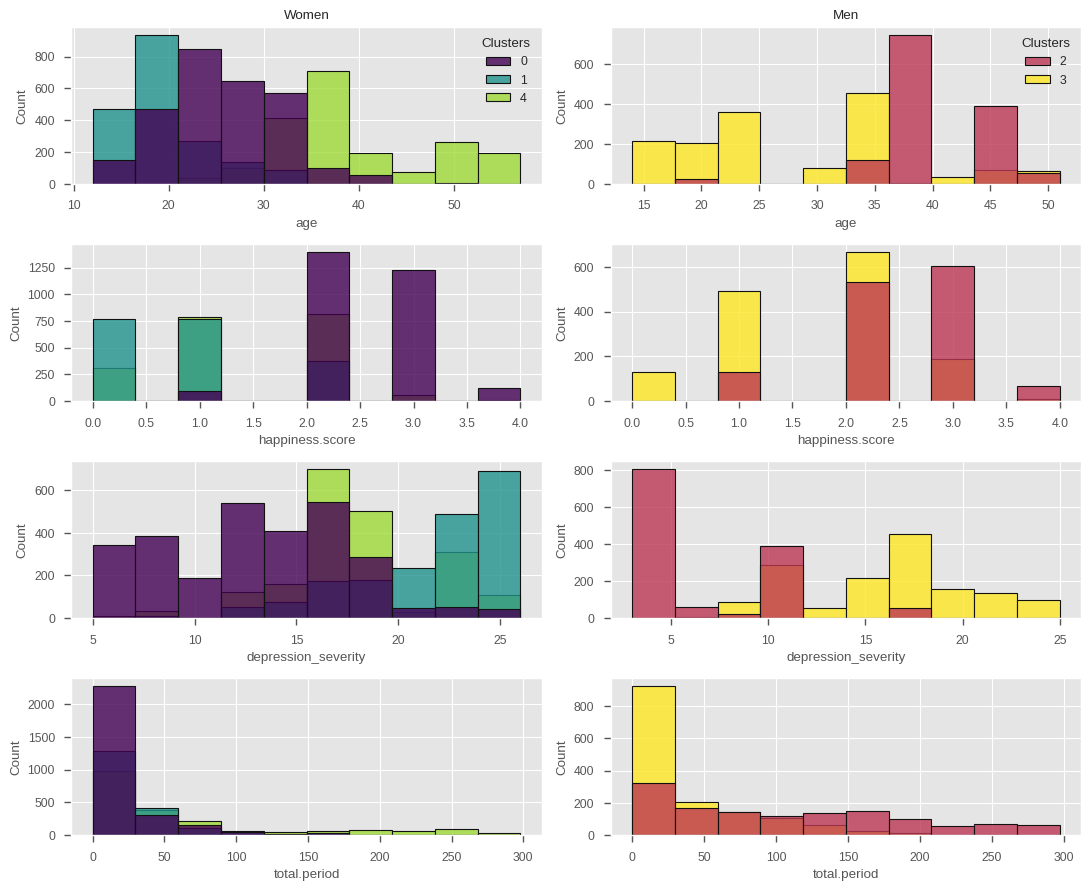

In [50]:
sns.set_context(context = 'paper', font_scale= 1)
plt.figure(figsize = (11,9))

ax = plt.subplot(4,2,1)
sns.histplot(x = 'age', data = df_fem, hue = 'Clusters',
             palette = ['#440154', '#21918c', '#a0da39'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax)

plt.title('Women')

ax = plt.subplot(4,2,2)
sns.histplot(x = 'age', data = df_mal, hue = 'Clusters',
             palette = ['#bc3754', '#fde725'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax)
plt.title('Men')

ax = plt.subplot(4,2,3)
sns.histplot(x = 'happiness.score', data = df_fem, hue = 'Clusters',
             palette = ['#440154', '#21918c', '#a0da39'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,4)
sns.histplot(x = 'happiness.score', data = df_mal, hue = 'Clusters',
             palette = ['#bc3754', '#fde725'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,5)
sns.histplot(x = 'depression_severity', data = df_fem, hue = 'Clusters',
            palette = ['#440154', '#21918c', '#a0da39'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)
ax = plt.subplot(4,2,6)
sns.histplot(x = 'depression_severity', data = df_mal, hue = 'Clusters',
             palette = ['#bc3754', '#fde725'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,7)
sns.histplot(x = 'total.period', data = df_fem, hue = 'Clusters',
             palette = ['#440154', '#21918c', '#a0da39'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,8)
sns.histplot(x = 'total.period', data = df_mal, hue = 'Clusters',
             palette = ['#bc3754', '#fde725'],
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)
plt.tight_layout()
plt.show()

From the analysis of the above graphs, we can see that:

Cluster 0: Mostly men under 35 years old who suffer from moderate/severe depression.

Cluster 1: Young women who suffer from moderate/severe depression.

Cluster 2: Elderly women who suffer from moderate/severe depression.

Cluster 3: Elderly men who have either mild or no depression symptoms.

Cluster 4: Young women who suffer from mild/moderate depression.

Based on the provided cluster analysis of depression levels using PHQ-9, the following clusters should be considered for clinical analysis and medical follow-up: Cluster 0, 1 and 2. These clusters have higher levels of depression severity and may require further medical attention and treatment. It is important to note that cluster analysis is just one tool in the assessment of depression and a more comprehensive evaluation is required for individualized treatment plans.